## Introdução

O pangenoma consiste no conjunto total de genes presentes nos genomas de organismos pertencentes a uma mesma espécie ou grupo taxonômico. Esse conjunto é composto pelo core e pelo acessório, existem outra denominaçõe que realacionam a presença do gene e a frequência dentro do popset, exemplos: cloud, shell, soft core e core. O  core engloba os genes compartilhados por todos os genomas, descrevendo as bases fundamentais da biologia do grupo taxonômico em questão, relacionando-se diretamente com suas características fisiológicas e fenotípicas essenciais. Por outro lado, o acessório, também conhecido como dispensável, representa os genes presentes em apenas alguns dos genomas analisados. Esses genes representam a diversidade dentro do grupo estudado, estando associados às adaptações específicas aos diferentes ambientes ocupados pelos organismos.

Esta aula abordará os seguintes temas:

* Obter e salvar dados brutos de sequenciamento
* Instalar softwares e preparar ambiente no Colab (conda/mamba)
* Controle de qualidade do sequenciamento (análise e trimagem)
* Alinhamento contra um genoma de referência, visualização e métricas
* Identificação de SNVs (polimorfismos/indels) e geração de consenso
* Classificação dos genomas em linhagens de SARS-CoV2
* Análise da qualidade dos consensos de SARS-CoV2

Use Ctrl+Enter para executar o conteúdo de uma 'célula' de código

Use Shift+Enter para executar código selecionado pelo mouse

Revisar o fluxo de trabalho da análise

# Baixando/importando dados

In [3]:
#!gdown 1JkUU3wcexm9Y532l6IbdIsdY4saMehJO
#Dados de sequenciamento em formato fastq e compactados em zip
!wget https://wcs_data_transfer.cog.sanger.ac.uk/Illumina_READS.zip
!unzip Illumina_READS.zip
!pwd
!ls

--2024-03-15 17:25:29--  https://wcs_data_transfer.cog.sanger.ac.uk/Illumina_READS.zip
Resolving wcs_data_transfer.cog.sanger.ac.uk (wcs_data_transfer.cog.sanger.ac.uk)... 193.62.203.61, 193.62.203.62, 193.62.203.63
Connecting to wcs_data_transfer.cog.sanger.ac.uk (wcs_data_transfer.cog.sanger.ac.uk)|193.62.203.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 704419521 (672M) [application/zip]
Saving to: ‘Illumina_READS.zip’

Illumina_READS.zip  100%[===================>] 671.79M  32.0MB/s    in 22s     

2024-03-15 17:25:51 (31.1 MB/s) - ‘Illumina_READS.zip’ saved [704419521/704419521]

Archive:  Illumina_READS.zip
  inflating: Illumina_fastq/samplesheet.csv  
  inflating: Illumina_fastq/fastq/ERR5761182_2.fastq.gz  
  inflating: Illumina_fastq/fastq/ERR5761182_1.fastq.gz  
  inflating: Illumina_fastq/fastq/ERR5914874_2.fastq.gz  
  inflating: Illumina_fastq/fastq/ERR5914874_1.fastq.gz  
  inflating: Illumina_fastq/fastq/ERR5921612_2.fastq.gz  
  inflating:

#Código Python para envio de dados à partir do computador local ou Google Drive

In [ ]:
#Código em Python para envio de arquivos para o Colab
from google.colab import files

uploaded = files.upload()

In [ ]:
#Código em Python para obter dados do Google Drive
from google.colab import drive

drive.mount('/content')

# Dados de sequenciamento Illumina - formato Fastq

Todos os sequenciadores de alta vazão produzem dados em um formato chamado **fastq**. A estrutura desses arquivos é mostrada abaixo. Todas as sequências com fastq são representadas por 4 linhas:

```
@SEQ_ID                   <---- Identificador da sequência
AGCGTGTACTGTGCATGTCGATG   <---- Sequência de nucleotídeos
+                         <---- Separador
%%).1***-+*''))**55CCFF   <---- ASCII - caracteres que representam a qualidade (phred score)

```

A qualidade das sequências é representada como um caractere do código ASCII. Verifique [aqui](https://help.basespace.illumina.com/files-used-by-basespace/quality-scores) para obter uma explicação .
Os valores numéricos correspondem aos valores de qualidade phred

10, 1 em 10	- 90%

20, 1 em 100	- 99%

30, 1 em 1000	- 99.9%

40, 1 em 10,000	- 99.99%

50, 1 em 100,000	- 99.999%

60, 1 em 1,000,000	- 99.9999%




In [4]:
#Cria um novo diretório (pasta)
!mkdir new

In [ ]:
# O comando cd significa “change directory”, ou “mudar de diretório”. Serve para navegar entre as pastas do computador
!cd new

In [ ]:
# “print working directory” - pwd. Serve para mostrar o caminho completo da pasta/diretório que estamos trabalhando no momento
!pwd

/content


In [ ]:
# O comando cd significa “change directory”, ou “mudar de diretório”. Serve para navegar entre as pastas do computador agora usando python
%cd new

/content/new


In [ ]:
# “print working directory” - pwd. Serve para mostrar o caminho completo da pasta/diretório que estamos trabalhando no momento
!pwd

/content/new


In [ ]:
#Mas vamos retornar ao nosso home para continuar a aula
%cd ../

/content


In [ ]:
#Listando novamente
!pwd

/content


In [ ]:
#Lista arquivos e diretórios locais
!ls -lh

In [ ]:
#Lista arquivos no diretório Illumina_fastq
!ls -l Illumina_fastq
#Imprime conteúdo do arquivo na tela (cat/zcat)
!zcat Illumina_fastq/fastq/ERR5761182_2.fastq.gz | head

In [ ]:
#Descomprime arquivos .gz
#!gunzip Illumina_fastq/fastq/ERR5761182_2.fastq.gz

In [ ]:
#Lista arquivos no diretório Illumina_fastq
!ls -lh Illumina_fastq/fastq

In [ ]:
#Lista os arquivos de exemplo do próprio Google Colab
!ls
!ls sample_data

#Instalando bibliotecas e o gerenciador conda através do Python

In [1]:
#Usando instalador de bibliotecas do Python (pip) para instalar o conda/mamba.
# Conda/Mamba é uma ferramenta que permite o gerenciamento de pacotes e ambientes.
# Que é um espaço isolado onde você pode instalar e executar ferramentas específicas para um projeto
!pip install --upgrade --force-reinstall zstandard cuda-python
!pip install -q condacolab

!sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned

#Código em Python
import condacolab
condacolab.install()

#Instala algumas dependências necessárias para os próximos passos
#conda-forge é um canal comunitário em que ficam ferramentas e pacotes
#bioconda é um canal especializado em bioinfomática
!mamba install -c conda-forge curl --quiet


#Lista os softwares do ambiente atual do conda/mamba
!mamba env list


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: zstandard
    Found existing installation: zstandard 0.22.0
    Uninstalling zstandard-0.22.0:
      Successfully uninstalled zstandard-0.22.0
✨🍰✨ Everything looks OK!
# conda environments:
#
base                     /usr/local



Leia mais sobre ambientes conda, mamba e sobre o canal bioconda nos links abaixo:
* [Conda](https://docs.conda.io/en/latest/)
* [Conda e ambientes virtuas](https://www.monolitonimbus.com.br/conda-e-ambientes-virtuais/)
* [Mamba](https://mamba.readthedocs.io/en/latest/user_guide/mamba.html)
* [Bioconda](https://bioinfo.imd.ufrn.br/transcricaoemdia/novidades/ne-007)


#Baixando o genoma de referência a anotações através do Entrez/NCBI

In [12]:
#Criando ambiente para baixar o genoma de referência e anotações
!mamba create -n entrez_ncbi
!mamba env list
!mamba install -c bioconda cmake entrez-direct --quiet
!mamba activate entrez_ncbi


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - \ | / done
Executing transaction: \ done

To activate this environment, use

     $ mamba activate entrez_ncbi

To deactivate an active environment, use

     $ mamba deactivate

# conda environments:
#
base                     /usr/local
bwa                      /usr/local/envs/bwa
entrez_ncbi              /usr/local/envs/entrez_ncbi
fastp                    /usr/local/envs/fastp
lineage                  /usr/local/envs/lineage
spades                   /usr/local/envs/spades

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.



In [13]:
#esearch busca no banco de dados do NCBI
#wget realiza o download
!esearch -db nucleotide -query NC_045512 | efetch -format fasta | awk '{print $1}' > NC_045512.fa
!wget -O NC_045512.gff "https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?db=nuccore&report=gff3&id=NC_045512"
!ls

--2024-03-15 18:08:35--  https://www.ncbi.nlm.nih.gov/sviewer/viewer.cgi?db=nuccore&report=gff3&id=NC_045512
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘NC_045512.gff’

NC_045512.gff           [ <=>                ]  14.36K  --.-KB/s    in 0.1s    

2024-03-15 18:08:35 (125 KB/s) - ‘NC_045512.gff’ saved [14704]

condacolab_install.log		fastp.json	    NC_045512.fa   sample_data
ERR5761182_denovo.fa.pango.csv	Illumina_fastq	    NC_045512.gff  spades_results
ERR5761182_denovo.fasta		Illumina_READS.zip  new		   trimmed


Leia mais sobre:
* [NCBI](https://www.ncbi.nlm.nih.gov)
* [O que é NCBI e quem trabalha aqui?](https://ncbiinsights.ncbi.nlm.nih.gov/2023/02/23/what-and-who-ncbi/)
* [O aqruivo GFF3](https://github.com/The-Sequence-Ontology/Specifications/blob/master/gff3.md)



In [ ]:
#Visualizar os arquivos baixados
!head NC_045512.fa
!head NC_045512.gff

#Análise de qualidade de um FASTQ com FastQC

In [ ]:
#Criando ambientes para o controle de qualidade
!mamba create -n quality
!mamba env list
!mamba activate quality
!mamba install -c bioconda fastqc multiqc --quiet

In [ ]:
#Executando o FastQC para gerar relatórios de qualidade das sequências
!ls ./Illumina_fastq/fastq
!fastqc ./Illumina_fastq/fastq/ERR5761182_1.fastq.gz
!ls ./Illumina_fastq/fastq

In [ ]:
#Código em Python para visualizar o relatório HTML gerado pelo FastQC
!pwd
!ls -lh ./Illumina_fastq/fastq/
import IPython
IPython.display.HTML('./Illumina_fastq/fastq/ERR5761182_1_fastqc.html')

Entenda mais sobre o relatório do FASTQC [aqui](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/).


#Remoção de leituras e bases de baixa qualidade usando fastp

In [2]:
#Criando ambiente virtual para remover bases de baixa qualidade (trimagem)
!mamba create -n fastp
!mamba activate fastp
!mamba install -c bioconda fastp --quiet
!mkdir trimmed


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - done
Executing transaction: | done

To activate this environment, use

     $ mamba activate fastp

To deactivate an active environment, use

     $ mamba deactivate

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [ ]:
# Verificando se a ferramenta foi apropriadamente instalada e executando o fastp para a trimagem.
!fastp

In [3]:
# Utilizando o fastp
# É comum se referir a esta etapa como "trimagem" e esses arquivos como "trimados"
!fastp -i ./Illumina_fastq/fastq/ERR5761182_1.fastq.gz -I ./Illumina_fastq/fastq/ERR5761182_2.fastq.gz --detect_adapter_for_pe -o ./trimmed/ERR5761182.R1.fq.gz -O ./trimmed/ERR5761182.R2.fq.gz -h ./trimmed/ERR5761182.fastp.html --qualified_quality_phred 20

Detecting adapter sequence for read1...
No adapter detected for read1

Detecting adapter sequence for read2...
ACGAGATGAAACATCTGTTGTCACTTACTGTACAAGCAAAGCAATATTGTCACTGCTACT

Read1 before filtering:
total reads: 177518
total bases: 38926840
Q20 bases: 38239644(98.2346%)
Q30 bases: 36645040(94.1382%)

Read2 before filtering:
total reads: 177518
total bases: 35393986
Q20 bases: 34472357(97.3961%)
Q30 bases: 32540884(91.939%)

Read1 after filtering:
total reads: 167802
total bases: 36783583
Q20 bases: 36135300(98.2376%)
Q30 bases: 34613589(94.1006%)

Read2 after filtering:
total reads: 167802
total bases: 33444305
Q20 bases: 32581558(97.4203%)
Q30 bases: 30747429(91.9362%)

Filtering result:
reads passed filter: 335604
reads failed due to low quality: 338
reads failed due to too many N: 156
reads failed due to too short: 18938
reads with adapter trimmed: 9474
bases trimmed due to adapters: 1900071

Duplication rate: 79.0185%

Insert size peak (evaluated by paired-end reads): 383

JSON repor

Leia mais sobre o fastp e seus paramêtros [aqui](https://github.com/mdshw5/fastqp).

#Relatório da ferramenta fastp

In [ ]:
#Visualizando o relatório gerado pelo fastp
!pwd
import IPython
#IPython.display.HTML(open('./trimmed/ERR5761182.fastp.html').read())
IPython.display.HTML('./trimmed/ERR5761182.fastp.html')

#Alinhamento das leituras de sequenciamento contra um genoma de referência

In [11]:
# Criando ambiente para bwa
!mamba create -n bwa
!mamba activate bwa
!mamba install -c bioconda bwa --quiet


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - \ | / done
Executing transaction: \ done

To activate this environment, use

     $ mamba activate bwa

To deactivate an active environment, use

     $ mamba deactivate

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [14]:
#Criando arquivo índice
!bwa index -p NC_045512 NC_045512.fa
# Criando pasta para colocar os arquivos pós-alinhamento
!mkdir aligned

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.01 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index -p NC_045512 NC_045512.fa
[main] Real time: 0.060 sec; CPU: 0.020 sec


In [15]:
# Alinhando as leituras trimadas contra a referência, gerando o arquivo de alinhamento .bam
!bwa mem NC_045512 ./trimmed/ERR5761182.R1.fq.gz ./trimmed/ERR5761182.R2.fq.gz -o ./aligned/ERR5761182.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 47626 sequences (10000241 bp)...
[M::process] read 47794 sequences (10000009 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 23778, 0, 0)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (386, 392, 395)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (368, 413)
[M::mem_pestat] mean and std.dev: (392.74, 8.48)
[M::mem_pestat] low and high boundaries for proper pairs: (359, 427)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 47626 reads in 2.998 CPU sec, 2.844 real sec
[M::process] read 47876 sequences (10000245 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 23893, 0, 0)
[M::mem_pestat] skip orientation F

Leia mais sobre bwa e seus paramêtros [aqui](https://github.com/lh3/bwa)

O que é um arquivo bam, veja [aqui](https://support.illumina.com/help/BS_App_RNASeq_Alignment_OLH_1000000006112/Content/Source/Informatics/BAM-Format.htm)?

In [16]:
# Criando ambiente para samtools e ivar para analisar e tratar os dados de alinhamento
!mamba create -n samtools_ivar
!mamba activate samtools_ivar
!mamba install -c bioconda samtools ivar --quiet


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - \ | / - done
Executing transaction: | done

To activate this environment, use

     $ mamba activate samtools_ivar

To deactivate an active environment, use

     $ mamba deactivate

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


Leia mais sobre samtools:
* [Github](https://github.com/samtools/samtools)
* [Manual]( http://www.htslib.org/doc/samtools.html)



#Organizando as leituras mapeadas e gerando estatísticas básicas

In [17]:
# Cria aquivo índice baseado no arquivo FASTA da referência
!samtools faidx NC_045512.fa
# Ordena as leituras de acordo com a posição no genoma
!samtools sort -o ./aligned/ERR5761182_sorted.bam ./aligned/ERR5761182.bam
# Indexa arquivos SAM, BAM ou CRAN compactados
!samtools index ./aligned/ERR5761182_sorted.bam
# Faz uma avaliação completa do arquivo para gerar estatísticas básicas
!samtools flagstat ./aligned/ERR5761182_sorted.bam

339821 + 0 in total (QC-passed reads + QC-failed reads)
335604 + 0 primary
0 + 0 secondary
4217 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
339819 + 0 mapped (100.00% : N/A)
335602 + 0 primary mapped (100.00% : N/A)
335604 + 0 paired in sequencing
167802 + 0 read1
167802 + 0 read2
326022 + 0 properly paired (97.14% : N/A)
335600 + 0 with itself and mate mapped
2 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


#Salvando leituras mapeadas

In [ ]:
# Imprime as primeiras leituras do arquivo BAM
!samtools view ./aligned/ERR5761182_sorted.bam | head

In [ ]:
# É posossível salvar somente as leituras que mapearam contra o genoma
!samtools view -b -F 4 ./aligned/ERR5761182_sorted.bam > ./aligned/ERR5761182_mapped.bam
!samtools fasta ./aligned/ERR5761182_mapped.bam > ERR5761182_mapped_reads.fasta
# Imprime as primeiras linhas do arquivo
!head ERR5761182_mapped_reads.fasta

#Visualizando alinhamento usando o IGV

In [ ]:
#Instalando o IGV
!pip install -q igv-notebook
# Clonando reposistório do github
!git clone https://github.com/igvteam/igv-notebook
!pwd
!head NC_045512.fa

In [ ]:
# Copiando os arquivos para o diretório /igv-notebook/examples/data
!cp NC_045512.fa NC_045512.fa.fai ./igv-notebook/examples/data
# Listando os arquivos dentro do diretório
!ls ./igv-notebook/examples/data
# Navegando até o diretório do IGV
!cd igv-notebook
# Listando os arquivos dentro do diretório aligned
!ls aligned

In [ ]:
#Código em Python usando a bilbioteca igv_notebook para visualização
import igv_notebook

igv_notebook.init()

b = igv_notebook.Browser(
    {
        "reference": {
            "id": "NC_045512",
            "name": "SARS-COV-2",
            "fastaPath": "./igv-notebook/examples/data/NC_045512.fa",
            "indexPath": "./igv-notebook/examples/data/NC_045512.fa.fai",
        },
        "locus": "NC_045512.2:7,476-22,427"
    }
)


b.load_track(
    {
        "name": "Local BAM",
        "path": "./aligned/ERR5761182_sorted.bam",
        "indexPath": "./aligned/ERR5761182_sorted.bam.bai",
        "format": "bam",
        "type": "alignment"
    })


b.zoom_in()

#Geração do consenso usando iVar

In [18]:
#!conda config --set restore_free_channel true
# Usando o ambiente do samtools_ivar para geração do consenso
!mamba activate samtools_ivar

!samtools mpileup

!samtools mpileup -aa -d 50000 --reference NC_045512.fa -a -B ./aligned/ERR5761182_sorted.bam | ivar variants -p ERR5761182 -q 30 -t 0.05

!samtools mpileup -aa -d 50000 --reference  NC_045512.fa -a -B ./aligned/ERR5761182_sorted.bam | ivar consensus -p ERR5761182 -q 30 -t 0 -m 30 -n N

!ls

!cat ERR5761182.fa

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.


Usage: samtools mpileup [options] in1.bam [in2.bam [...]]

Input options:
  -6, --illumina1.3+      quality is in the Illumina-1.3+ encoding
  -A, --count-orphans     do not discard anomalous read pairs
  -b, --bam-list FILE     list of input BAM filenames, one per line
  -B, --no-BAQ            disable BAQ (per-Base Alignment Quality)
  -C, --adjust-MQ INT     adjust mapping quality; recommended:50, disable:0 [0]
  -d, --max-depth INT     max per-file depth; avoids excessive memory usage [8000]
  -E, --redo-BAQ          recalculate BAQ on the fly, ignore existing BQs
  -f, --fasta-ref FILE    faidx indexed reference sequence file
  -G, --exclude-RG FILE   exclude read groups listed in FILE
  -l, --positions FILE    skip unlisted positions (chr pos) or regions (BED)
  -q, --min-MQ INT        skip alignments with mapQ smaller than INT [0]
  -Q, --min-BQ INT 

#Montagem *de novo* utilizando Spades

In [4]:
# Criando ambiente Spades
!mamba create -n spades
!mamba activate spades --quiet
!mamba install -c bioconda spades


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - done
Executing transaction: | done

To activate this environment, use

     $ mamba activate spades

To deactivate an active environment, use

     $ mamba deactivate

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.


Looking for: ['spades']

bioconda/linux-64                                           Using cache
bioconda/noarch                                             Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.10.*
  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  Updating specs:

   - spades
   - ca-certificates
   - certifi
   - openssl


  Package                                 Version  Build        Channel       

Leia mais sobe Spades [aqui](https://github.com/ablab/spades).

In [5]:
#Executando o comando para montagem 'de novo' usando o Spades
!spades.py --pe1-1 ./trimmed/ERR5761182.R1.fq.gz --pe1-2 ./trimmed/ERR5761182.R2.fq.gz -o spades_results

!ls ./spades_results
!cat ./spades_results/scaffolds.fasta



== Warning ==  No assembly mode was specified! If you intend to assemble high-coverage multi-cell/isolate data, use '--isolate' option.


Command line: /usr/local/bin/spades.py	--pe1-1	/content/trimmed/ERR5761182.R1.fq.gz	--pe1-2	/content/trimmed/ERR5761182.R2.fq.gz	-o	/content/spades_results	

System information:
  SPAdes version: 3.15.5
  Python version: 3.10.13
  OS: Linux-6.1.58+-x86_64-with-glibc2.35

Output dir: /content/spades_results
Mode: read error correction and assembling
Debug mode is turned OFF

Dataset parameters:
  Standard mode
  For multi-cell/isolate data we recommend to use '--isolate' option; for single-cell MDA data use '--sc'; for metagenomic data use '--meta'; for RNA-Seq use '--rna'.
  Reads:
    Library number: 1, library type: paired-end
      orientation: fr
      left reads: ['/content/trimmed/ERR5761182.R1.fq.gz']
      right reads: ['/content/trimmed/ERR5761182.R2.fq.gz']
      interlaced reads: not specified
      single reads: not specified
      merg

#Estatísticas básicas de um FASTA

In [6]:
# Instalando o seqstats
!mamba install -c bioconda seqstats


Looking for: ['seqstats']

[+] 0.0s
bioconda/linux-64  ⣾  [+] 0.1s
bioconda/linux-64     ⣾  
bioconda/noarch       ⣾  
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  conda-forge/linux-64                                          No change
[+] 0.2s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch   3%[+] 0.3s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  26%[+] 0.4s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  50%[+] 0.5s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  61%[+] 0.6s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  73%[+] 0.7s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  85%[+] 0.8s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch  97%[+] 0.9s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch 100%[+] 1.0s
bioconda/linux-64   ⣾  
bioconda/noarch     ⣾  
conda-forge/noarch 100%conda-forge/noarch                   

In [7]:
# Copiando arquivo de resultado do spades e renomeando
!cp ./spades_results/scaffolds.fasta ERR5761182_denovo.fasta
# Usando seqstats para análise de métricas dos contigs montados pelo Spades
!seqstats ERR5761182_denovo.fasta

Total n:	14
Total seq:	30268 bp
Avg. seq:	2162.00 bp
Median seq:	138.50 bp
N 50:		8439 bp
Min seq:	79 bp
Max seq:	9388 bp


#Definição de linhagem utilizando Pangolin

In [8]:
#Criando ambiente para o Pangolin e Nextclade
!mamba create -n lineage
!mamba activate lineage
!mamba install -c bioconda pangolin nextclade --quiet


Looking for: []

Preparing transaction: - done
Verifying transaction: | / - \ | done
Executing transaction: - done

To activate this environment, use

     $ mamba activate lineage

To deactivate an active environment, use

     $ mamba deactivate

Run 'mamba init' to be able to run mamba activate/deactivate
and start a new shell session. Or use conda to activate/deactivate.

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [9]:
# O paramêtro --help imprime uma mensagem com informações básicas das ferramentas e como usá-la
!pangolin --help

usage: pangolin <query> [options]

pangolin: Phylogenetic Assignment of Named Global Outbreak LINeages

positional arguments:
  query

options:
  -h, --help            show this help message and exit
  -o OUTDIR, --outdir OUTDIR
                        Output directory. Default: current working directory
  --outfile OUTFILE     Optional output file name. Default: lineage_report.csv
  -d DATA, --data DATA  Data directory minimally containing a fasta alignment and guide tree
  -n, --dry-run         Go through the motions but don't actually run
  -f, --force           Overwrite all output
  --tempdir TEMPDIR     Specify where you want the temp stuff to go. Default: $TMPDIR
  --max-ambig MAXAMBIG  Maximum proportion of Ns allowed for pangolin to attempt assignment.
                        Default: 0.5
  --min-length MINLEN   Minimum query length allowed for pangolin to attempt assignment. Default:
                        10000
  --panGUIlin           Run web-app version of pangolin
  --wri

In [10]:
!pwd
!ls
!pangolin ./ERR5761182_denovo.fasta --outfile ERR5761182_denovo.fa.pango.csv

/content
condacolab_install.log	 fastp.json	 Illumina_READS.zip  sample_data     trimmed
ERR5761182_denovo.fasta  Illumina_fastq  new		     spades_results
Found the snakefile
The query file is /content/./ERR5761182_denovo.fasta
NODE_1_length_9388_cov_1445.849855 	sequence too short
NODE_2_length_8439_cov_1110.533365 	sequence too short
NODE_3_length_4724_cov_1746.605767 	sequence too short
NODE_4_length_2427_cov_1364.702553 	sequence too short
NODE_5_length_2224_cov_1774.009781 	sequence too short
NODE_6_length_2212_cov_2503.828103 	sequence too short
NODE_7_length_154_cov_76.441558 	sequence too short
NODE_8_length_123_cov_29.804348 	sequence too short
NODE_9_length_109_cov_346.593750 	sequence too short
NODE_10_length_109_cov_12.250000 	sequence too short
NODE_11_length_109_cov_11.968750 	sequence too short
NODE_12_length_91_cov_981.571429 	sequence too short
NODE_13_length_80_cov_6.333333 	sequence too short
NODE_14_length_79_cov_4.000000 	sequence too short
Number of threads is 1
L

Leia mais sobre Pagolin [aqui](https://github.com/stevenlovegrove/Pangolin)

In [19]:
# Usando Pangolin para anotação de linhagens da montagem por referência
!pangolin ERR5761182.fa --outfile ERR5761182.fa.pango.csv

#Verificando resultado da montagem por referência
!cat ERR5761182.fa.pango.csv

# Usando Pangolin para anotação de linhagens da montagem 'de novo'
!pangolin ERR5761182_denovo.fasta --outfile ERR5761182_denovo.fa.pango.csv

#Verificando resultado da montagem 'de novo'
!cat ERR5761182_denovo.fa.pango.csv

Found the snakefile
The query file is /content/ERR5761182.fa
Number of threads is 1
Looking in /usr/local/lib/python3.10/site-packages/lineages/data for data files...

Data files found
Sequence alignment:	/usr/local/lib/python3.10/site-packages/lineages/data/anonymised.encrypted.aln.safe.fasta
Guide tree:		/usr/local/lib/python3.10/site-packages/lineages/data/anonymised.aln.safe.fasta.treefile
Lineages csv:		/usr/local/lib/python3.10/site-packages/lineages/data/lineages.metadata.csv
Job counts:
	count	jobs
	1	all
	1	assign_lineages
	1	decrypt_aln
	1	pass_query_hash
	4
Job counts:
	count	jobs
	1	decrypt_aln
	1
Decrypted 321 sequences
Job counts:
	count	jobs
	1	pass_query_hash
	1
1 hashed sequences written
Job counts:
	count	jobs
	1	assign_lineages
	1
Passing 1 into processing pipeline.
snakemake --nolock --snakefile /usr/local/lib/python3.10/site-packages/pangolin/scripts/assign_query_lineage.smk --directory /tmp/tmptmrevzq8 --configfile /tmp/tmptmrevzq8/config.yaml --config outdir=/con

In [20]:
!cat ERR5761182.fa.pango.csv

taxon,lineage,SH-alrt,UFbootstrap,lineages_version,status,note
Consensus_ERR5761182_threshold_0_quality_30,B.1.1,100,99,2020-05-19,passed_qc,


#Definição de linhagem e avaliação do consenso com Nextclade

In [21]:
# O paramêtro --help imprime uma mensagem com informações básicas das ferramentas e como usá-la
!nextclade --help

Viral genome alignment, mutation calling, clade assignment, quality checks and phylogenetic placement.

Nextclade is a part of Nextstrain: https://nextstrain.org

Documentation: https://docs.nextstrain.org/projects/nextclade
Nextclade Web: https://clades.nextstrain.org
Publication:   https://doi.org/10.21105/joss.03773

For short help type: `nextclade -h`, for extended help type: `nextclade --help`. Each subcommand has its own help, for example: `nextclade run --help`.

Usage: nextclade [OPTIONS] <COMMAND>

Commands:
  completions      Generate shell completions
  run              Run sequence analysis: alignment, mutation calling, clade assignment, quality checks and phylogenetic placement
  dataset          List and download available Nextclade datasets (pathogens)
  sort             Sort sequences according to the inferred Nextclade dataset (pathogen)
  read-annotation  Read genome annotation and present it in Nextclade's internal formats. This is mostly only useful for Nextclade ma

Leia mais sobre Nextclade
* [Github](https://github.com/nextstrain/nextclade)
* [Documentação](https://docs.nextstrain.org/projects/nextclade/en/stable/)

In [22]:
# Usando nextclade para anotação de linhagens
!nextclade dataset get --name 'sars-cov-2' --output-dir 'data/sars-cov-2'
!nextclade run --input-dataset data/sars-cov-2 --output-all=output_nextclade ERR5761182.fa


In [23]:
# Avaliando resultados
!ls ./output_nextclade
!cat ./output_nextclade/nextclade.csv

nextclade.aligned.fasta		       nextclade.cds_translation.ORF3a.fasta  nextclade.csv
nextclade.auspice.json		       nextclade.cds_translation.ORF6.fasta   nextclade.json
nextclade.cds_translation.E.fasta      nextclade.cds_translation.ORF7a.fasta  nextclade.ndjson
nextclade.cds_translation.M.fasta      nextclade.cds_translation.ORF7b.fasta  nextclade.nwk
nextclade.cds_translation.N.fasta      nextclade.cds_translation.ORF8.fasta   nextclade.tsv
nextclade.cds_translation.ORF1a.fasta  nextclade.cds_translation.ORF9b.fasta
nextclade.cds_translation.ORF1b.fasta  nextclade.cds_translation.S.fasta
index;seqName;clade;Nextclade_pango;partiallyAliased;clade_nextstrain;clade_who;clade_display;qc.overallScore;qc.overallStatus;totalSubstitutions;totalDeletions;totalInsertions;totalFrameShifts;totalMissing;totalNonACGTNs;totalAminoacidSubstitutions;totalAminoacidDeletions;totalAminoacidInsertions;totalUnknownAa;alignmentScore;alignmentStart;alignmentEnd;coverage;isReverseComplement;substitutions;d

Leia mais sobre containers/docker:
* [Container Docker](https://www.meupositivo.com.br/panoramapositivo/container-docker/)
*[Aplicação de containers](https://www.docker.com/resources/what-container/)
*[Desmistificando container](https://cloudblogs.microsoft.com/opensource/2019/07/15/how-to-get-started-containers-docker-kubernetes/)

#Exemplo: ViralFlow, um workflow para automação da montagem de genomas virais

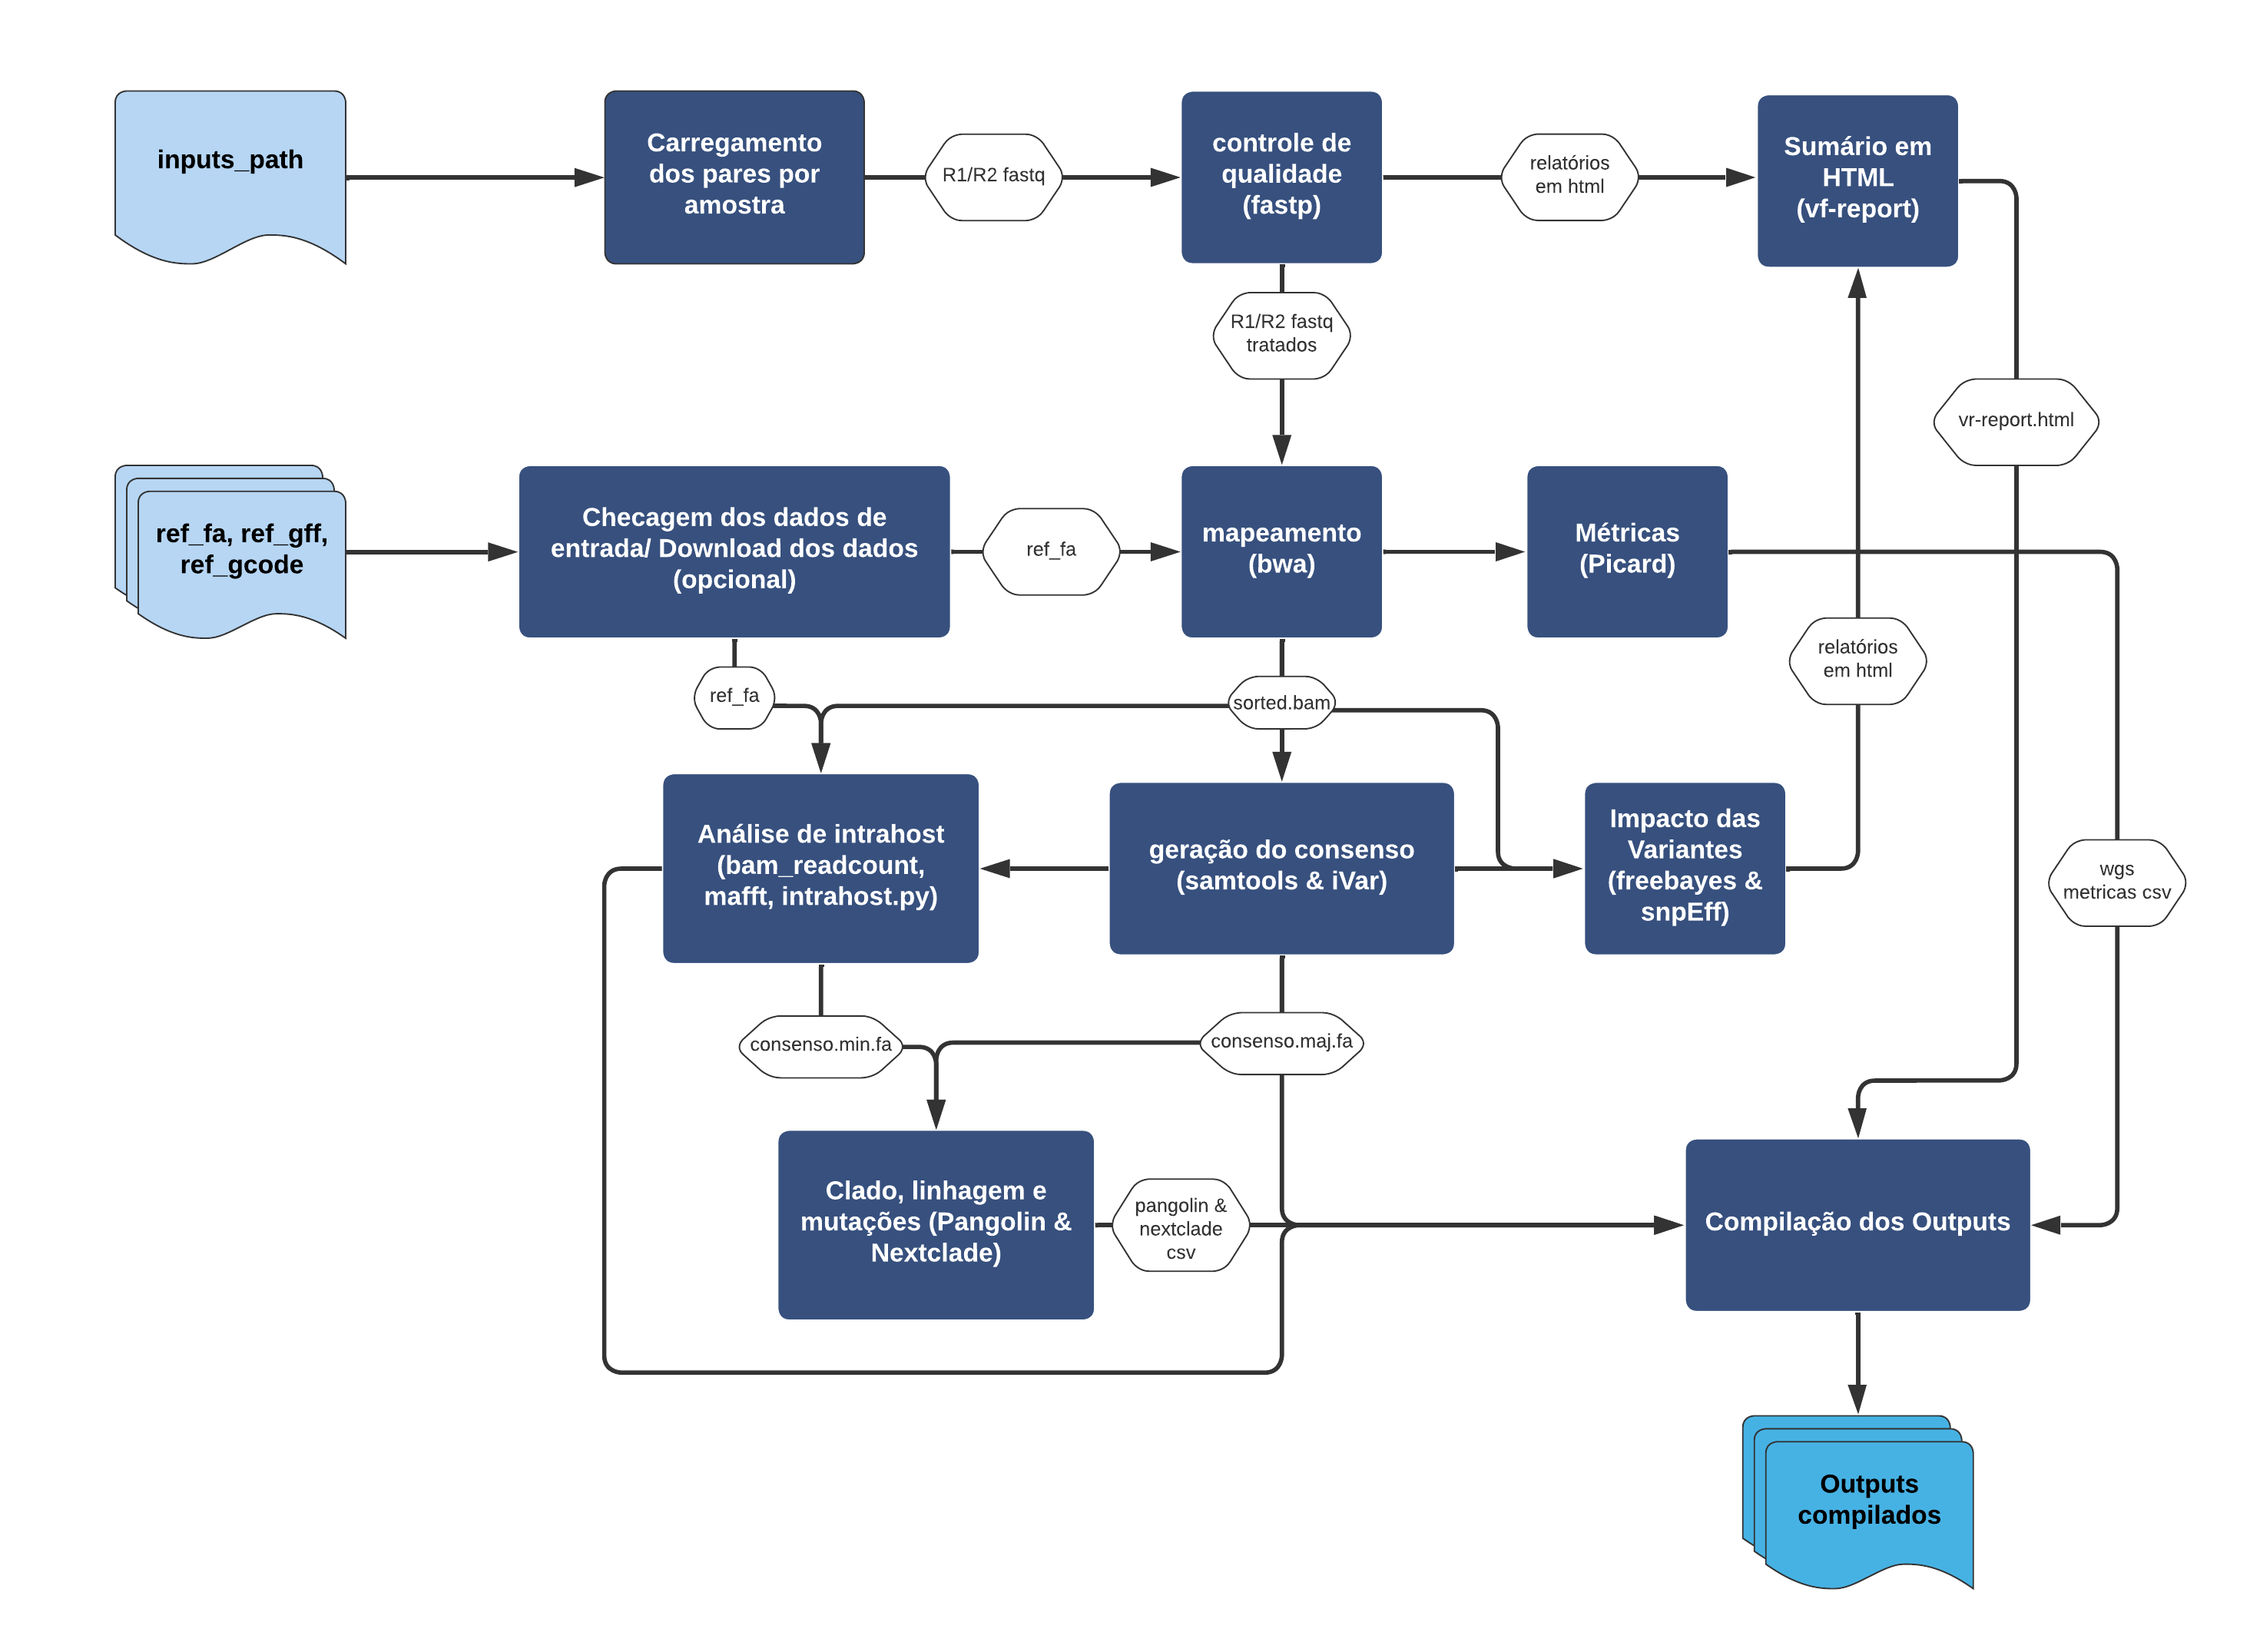

Leia mais sobr ViralFlow
* [Github](https://viralflow.github.io)
* [Artigo](https://www.arca.fiocruz.br/handle/icict/52429?locale-attribute=pt_BR)

## **Sua vez de praticar**

No diretório exercise têm 4 sequências:
1. Avalie a qualidade delas utilizando o FastQC
2. Utilize os comando wget para baixar os arquivos do exercício
3. Descomprima usando o comando unzip
4. Utilize os arquivos sample_0*.gz
5. Use os comandos cd e ls para navegar entre os diretórios e verificar os arquivos.
6. Lembre-se de colocar os caminhos completos.
7.  Crie quantas células de códigos achar necessário

In [ ]:
!wget https://github.com/khourious/IGM-TRAIN/raw/main/course_data/exercise.zip

In [ ]:
!unzip exercise

In [ ]:
#Exemplo
!ls
!cd exercise/sample_1

Use o ambiente criado anteriormente para controle de qualidade para avaliar as sequências do diretório exercise

In [ ]:
!mamba activate quality

In [ ]:
#Use esse espaço para fazer o controle de qualidade da sample_1






In [ ]:
#Para visualizar o relatório HTML, use o código em Python
#Substitua o caminho ""./Illumina_fastq/fastq/ERR5761182_1_fastqc.html" para o que deseja
import IPython
IPython.display.HTML('./Illumina_fastq/fastq/ERR5761182_1_fastqc.html')

In [ ]:
#Use esse espaço para fazer o controle de qualidade da sample_2






In [ ]:
#Use esse espaço para fazer o controle de qualidade da sample_3






In [ ]:
#Use esse espaço para fazer o controle de qualidade da sample_4




